---
title: "Manual embedding of Bi-LSTM model on ProteomeTools data"

date: last-modified

author:

- name: Tobias Greisager Rehfeldt

  orcid: 0000-0002-1190-9485

  affiliations:
    - University of Southern Denmark, Odense
    - Department of Natural Science, Institute for Mathematics and Computer Science

---

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ProteomicsML/ProteomicsML/blob/main/tutorials/retentiontime/_manual-prosit-rt.ipynb)

In [ ]:
 !pip install pandas==1.3.5 sklearn==0.0.post1 tensorflow==2.9.2 numpy==1.21.6 matplotlib==3.2.2 requests==2.23.0 --quiet

In [ ]:
# Import and normalize/standarize data
import pandas as pd
import numpy as np
# Import and normalize the data
data = pd.read_csv('https://github.com/ProteomicsML/ProteomicsML/blob/main/datasets/retentiontime/ProteomeTools/small.zip?raw=true', compression='zip')

# shuffle and split dataset into internal (80%) and external (20%) datasets
data = data.sample(frac=1)
test_data = data[int(len(data)*0.8):]
data = data[:int(len(data)*0.8)]

In [ ]:
# Split the internal dataset into training and validation
# We have to split the data based on Sequences, to make sure we dont have cross-over sequences in the training and validation splits.
unique_sequences = list(set(data['sequence']))
# Shuffle the data to ensure unbiased data splitting
from random import shuffle
shuffle(unique_sequences)
# Split sequence 80-10-10 training, validation and testing split
train = unique_sequences[0:int(len(unique_sequences) * 0.8)]
validation = unique_sequences[int(len(unique_sequences) * 0.8):]
# Transfer the sequence split into data split
train = data[data['sequence'].isin(train)]
validation = data[data['sequence'].isin(validation)]
print('Training data points:', len(train),'  Validation data points:',  len(validation),'  Testing data points:',  len(test_data))
# Here we use test as an external dataset unlike the one used for training.

Training data points: 64355   Validation data points: 15645   Testing data points: 20000


In [ ]:
normalize = True
if normalize:
  # Normalize
  train_val_min, train_val_max = min(train['retention time'].min(), validation['retention time'].min()), max(train['retention time'].max(), validation['retention time'].max())
  train['retention time'] = list((train['retention time'] - train_val_min) / (train_val_max - train_val_min))
  validation['retention time'] = list((validation['retention time'] - train_val_min) / (train_val_max - train_val_min))
  test_data['retention time'] = list((test_data['retention time'] - test_data['retention time'].min()) / (test_data['retention time'].max() - test_data['retention time'].min()))
else:
  # Standardize
  train_val_mean, train_val_std = np.mean(list(train['retention time']) + list(validation['retention time'])), np.std(list(train['retention time']) + list(validation['retention time']))
  train['retention time'] = (train['retention time'] - train_val_mean) / train_val_std
  validation['retention time'] = (validation['retention time'] - train_val_mean) / train_val_std
  test_data['retention time'] = (test_data['retention time'] - np.mean(test_data['retention time'])) / np.std(test_data['retention time'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Setup parameters
sequence_length = 30
batch_size = 64
epochs=10

In [ ]:
# Manual sequence embedding
# Remove sequences longer than our maximum sequence length
train = train[train['sequence'].str.len()<=sequence_length]
validation = validation[validation['sequence'].str.len()<=sequence_length]
test_data = test_data[test_data['sequence'].str.len()<=sequence_length]

# Create an alphabet to convert from string to numeric
AA_alphabet = {"A": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "H": 7, "I": 8, "K": 9, "L": 10, "M": 11, "N": 12, "P": 13, "Q": 14, "R": 15, "S": 16, "T": 17, "V": 18, "W": 19, "Y": 20}
# Convert sequences from string to numberic
embedded_sequences_train = [[AA_alphabet[g] for g in f] for f in train['sequence']]
embedded_sequences_validation = [[AA_alphabet[g] for g in f] for f in validation['sequence']]
embedded_sequences_test = [[AA_alphabet[g] for g in f] for f in test_data['sequence']]

# Make sure every sequence is the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
embedded_sequences_train = pad_sequences(sequences=embedded_sequences_train, maxlen=sequence_length)
embedded_sequences_validation = pad_sequences(sequences=embedded_sequences_validation, maxlen=sequence_length)
embedded_sequences_test = pad_sequences(sequences=embedded_sequences_test, maxlen=sequence_length)

In [ ]:
# Import the needed layers and tensorflow model requirements
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Concatenate, Bidirectional, Dropout
from tensorflow.keras.models import Model

inputs = Input(shape=(sequence_length,), name='Input')
# Embed the sequnces in a 20 x 8 matrix
input_embedding = Embedding(input_dim=len(AA_alphabet)+2, output_dim=8, name='Sequence_Embedding')(inputs)
x = Bidirectional(LSTM(32, return_sequences=True), name='Bi_LSTM_1')(input_embedding)
x = Dropout(0.25, name='LSTM_Dropout')(x)
x = Bidirectional(LSTM(32), name='Bi_LSTM_2')(x)
output = Dense(1, activation="linear", name='Output')(x)
model = Model(inputs, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 30)]              0         
                                                                 
 Sequence_Embedding (Embeddi  (None, 30, 8)            176       
 ng)                                                             
                                                                 
 Bi_LSTM_1 (Bidirectional)   (None, 30, 64)            10496     
                                                                 
 LSTM_Dropout (Dropout)      (None, 30, 64)            0         
                                                                 
 Bi_LSTM_2 (Bidirectional)   (None, 64)                24832     
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                             

In [ ]:
import tensorflow as tf
# Compiling the keras model with loss function, metrics and optimizer
model.compile(loss='mse', metrics=['mae'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
# Train the model
history = model.fit(x=embedded_sequences_train, y=train['retention time'], epochs=epochs, 
                    batch_size=batch_size, validation_data=(embedded_sequences_validation, validation['retention time']))

Epoch 1/10
1004/1004 [==============================] - 30s 16ms/step - loss: 0.0078 - mae: 0.0571 - val_loss: 0.0039 - val_mae: 0.0439
Epoch 2/10
1004/1004 [==============================] - 13s 13ms/step - loss: 0.0036 - mae: 0.0399 - val_loss: 0.0033 - val_mae: 0.0400
Epoch 3/10
1004/1004 [==============================] - 13s 13ms/step - loss: 0.0029 - mae: 0.0349 - val_loss: 0.0027 - val_mae: 0.0323
Epoch 4/10
1004/1004 [==============================] - 13s 13ms/step - loss: 0.0026 - mae: 0.0330 - val_loss: 0.0023 - val_mae: 0.0302
Epoch 5/10
1004/1004 [==============================] - 14s 14ms/step - loss: 0.0023 - mae: 0.0311 - val_loss: 0.0020 - val_mae: 0.0286
Epoch 6/10
1004/1004 [==============================] - 13s 13ms/step - loss: 0.0022 - mae: 0.0301 - val_loss: 0.0020 - val_mae: 0.0292
Epoch 7/10
1004/1004 [==============================] - 13s 13ms/step - loss: 0.0022 - mae: 0.0293 - val_loss: 0.0019 - val_mae: 0.0273
Epoch 8/10
1004/1004 [==========================

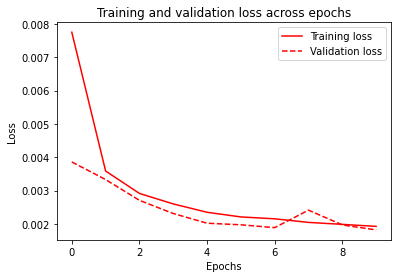

In [ ]:
import matplotlib.pyplot as plt
# Plotting the training history 
plt.plot(range(epochs), history.history['loss'], '-', color='r', label='Training loss')
plt.plot(range(epochs), history.history['val_loss'], '--', color='r', label='Validation loss')
plt.title(f'Training and validation loss across epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/10
312/312 [==============================] - 4s 12ms/step - loss: 0.0023 - mae: 0.0291
Epoch 2/10
312/312 [==============================] - 4s 12ms/step - loss: 0.0022 - mae: 0.0287
Epoch 3/10
312/312 [==============================] - 4s 12ms/step - loss: 0.0021 - mae: 0.0285
Epoch 4/10
312/312 [==============================] - 4s 12ms/step - loss: 0.0021 - mae: 0.0281
Epoch 5/10
312/312 [==============================] - 4s 12ms/step - loss: 0.0020 - mae: 0.0276
Epoch 6/10
312/312 [==============================] - 4s 12ms/step - loss: 0.0019 - mae: 0.0272
Epoch 7/10
312/312 [==============================] - 4s 12ms/step - loss: 0.0020 - mae: 0.0277
Epoch 8/10
312/312 [==============================] - 4s 12ms/step - loss: 0.0019 - mae: 0.0271
Epoch 9/10
312/312 [==============================] - 4s 12ms/step - loss: 0.0020 - mae: 0.0278
Epoch 10/10
312/312 [==============================] - 4s 12ms/step - loss: 0.0019 - mae: 0.0272


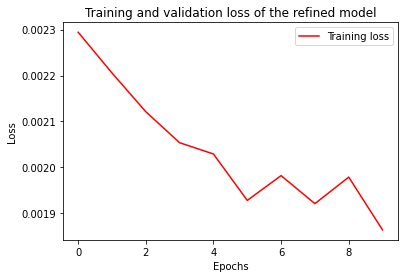

In [ ]:
# Initially we trained on just one gradient, to transfer this model to external datasets, 
# we refine the model by using the model we just trained as a pre-trained model, and then further train it with the test/external dataset
history = model.fit(x=embedded_sequences_test, y=test_data['retention time'], epochs=epochs, batch_size=batch_size)
# The model can now be used for other datasets with the same gradient set-up
# We then plot the history of this model, and see the initial performance is much better, 
# as the model already has some gradient agnostic knowledge, and it simply has to learn the new gradients
plt.plot(range(epochs), history.history['loss'], '-', color='r', label='Training loss')
plt.title(f'Training and validation loss of the refined model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()